In [54]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import math
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


# Fetching Data

In [55]:
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'FB', 'NVDA', 'NFLX', 'INTC', 'AMD',
    'IBM', 'ORCL', 'CSCO', 'ADBE', 'PYPL', 'QCOM', 'TXN', 'AVGO', 'CRM', 'SAP'
]
start_date = '2019-05-17'
end_date = '2025-05-29'

In [56]:
def download_and_format_stock_data(ticker, start_date, end_date, retries=3):
    for i in range(retries):
        try:
            stock_data = yf.download(ticker, start=start_date, end=end_date)
            if not stock_data.empty:
                stock_data.reset_index(inplace=True)
                stock_data['Name'] = ticker
                stock_data = stock_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Name']]
                stock_data.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'name']
                return stock_data
        except Exception as e:
            print(f"Attempt {i+1} failed for {ticker}: {e}")
    return pd.DataFrame()

In [57]:
all_stocks_data = pd.concat([download_and_format_stock_data(ticker, start_date, end_date) for ticker in tickers])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['FB']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 o

In [58]:
print(all_stocks_data.head())

file_path = 'formatted_stock_data2.csv'
all_stocks_data.to_csv(file_path, index=False)

        date       open       high        low      close     volume  name
0 2019-05-17  44.891454  45.844855  44.850629  45.388569  131516400  AAPL
1 2019-05-20  44.072551  44.271877  43.294460  43.969284  154449200  AAPL
2 2019-05-21  44.480812  45.148432  44.355932  44.812222  113459200  AAPL
3 2019-05-22  44.346326  44.598485  43.839606  43.894840  118994400  AAPL
4 2019-05-23  43.179194  43.356903  42.701291  43.145573  146118800  AAPL


In [59]:
print(f"Data saved to {file_path}")

Data saved to formatted_stock_data2.csv


# EDA

### Data sanity check

In [60]:
print(f"Rows x columns : {all_stocks_data.shape}")
display(all_stocks_data.isna().sum())

Rows x columns : (28804, 7)


date      0
open      0
high      0
low       0
close     0
volume    0
name      0
dtype: int64

### Checking closing prices

In [61]:
close_px = (
    all_stocks_data
    .pivot(index="date", columns="name", values="close")
    .sort_index()
)

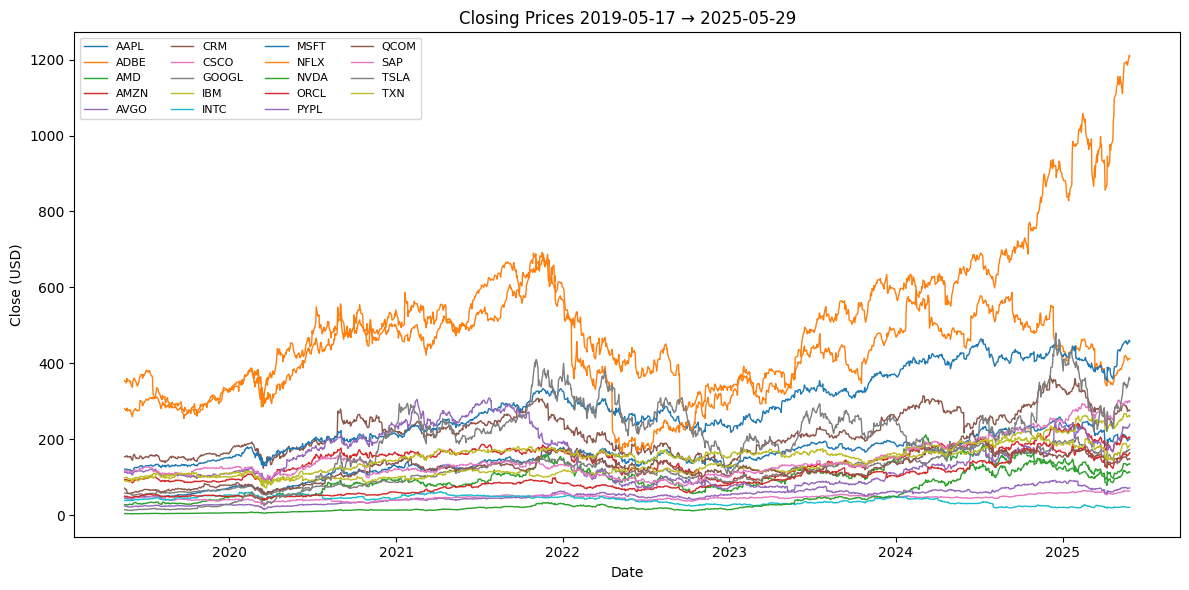

In [62]:
plt.figure(figsize=(12, 6))
for col in close_px.columns:
    plt.plot(close_px.index, close_px[col], lw=1, label=col)
plt.title("Closing Prices 2019-05-17 → 2025-05-29")
plt.xlabel("Date"); plt.ylabel("Close (USD)")
plt.legend(ncol=4, fontsize=8)
plt.tight_layout()
plt.show()

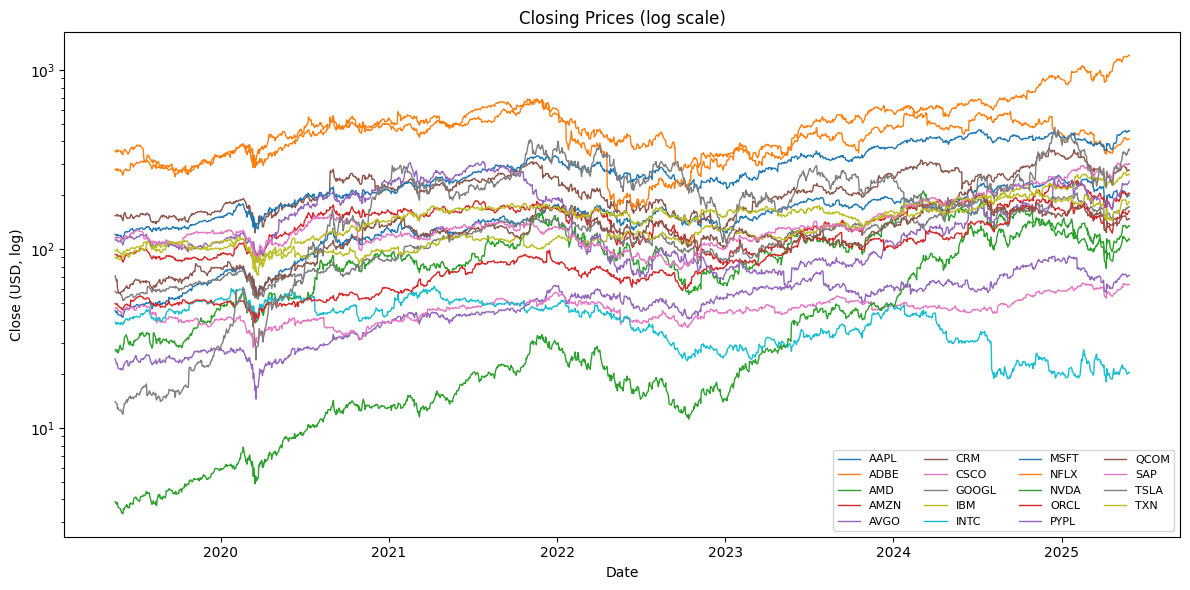

In [63]:
plt.figure(figsize=(12, 6))
for col in close_px.columns:
    plt.semilogy(close_px.index, close_px[col], lw=1, label=col)
plt.title("Closing Prices (log scale)")
plt.xlabel("Date"); plt.ylabel("Close (USD, log)")
plt.legend(ncol=4, fontsize=8)
plt.tight_layout()
plt.show()

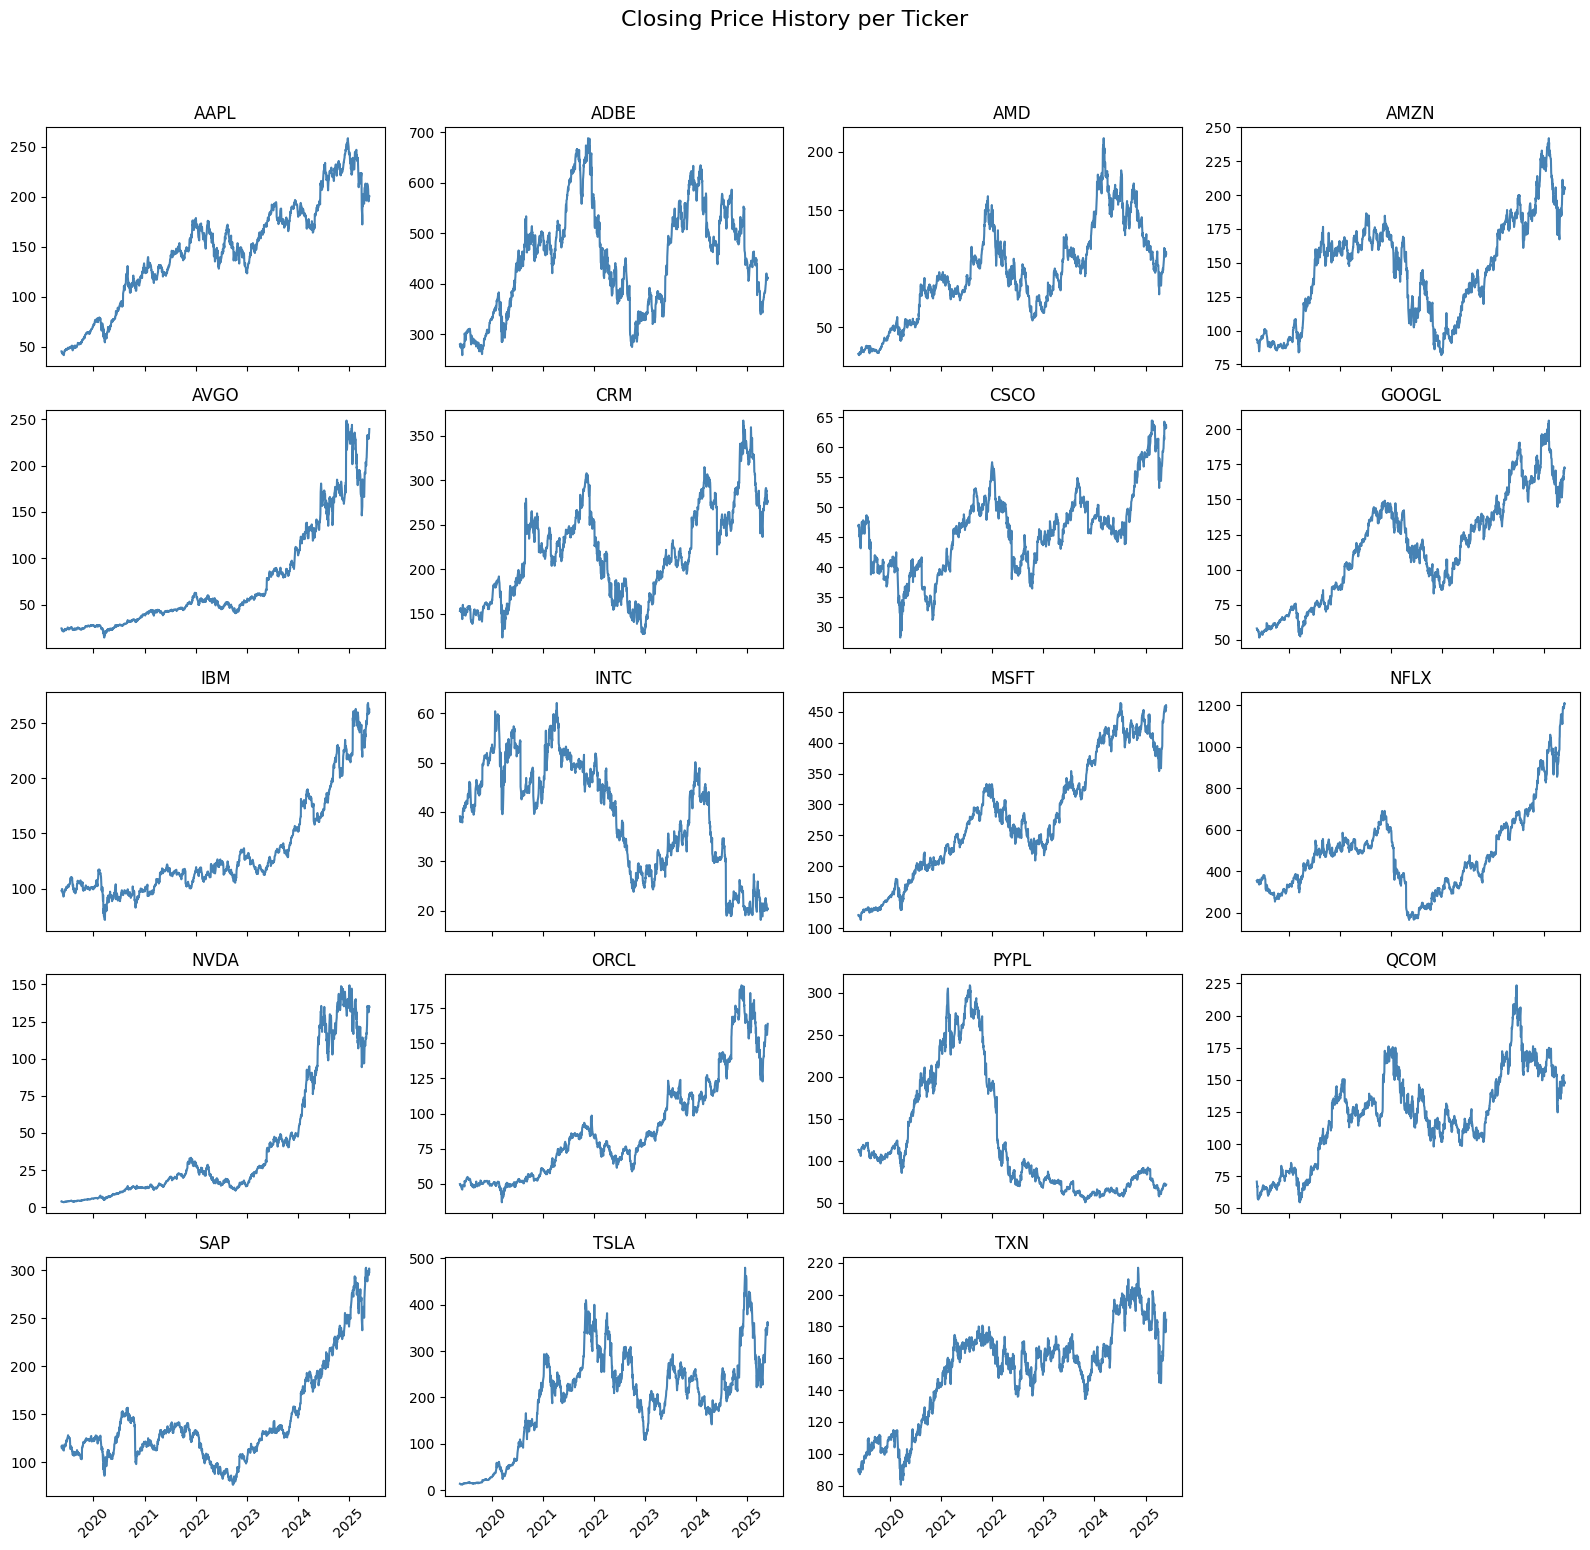

In [64]:
n = close_px.shape[1]
cols = 4
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3), sharex=True)
axes = axes.flatten()

for i, col in enumerate(close_px.columns):
    axes[i].plot(close_px.index, close_px[col], color="steelblue")
    axes[i].set_title(col)
    axes[i].tick_params(axis="x", rotation=45)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Closing Price History per Ticker", y=1.03, fontsize=16)
fig.tight_layout()
plt.show()

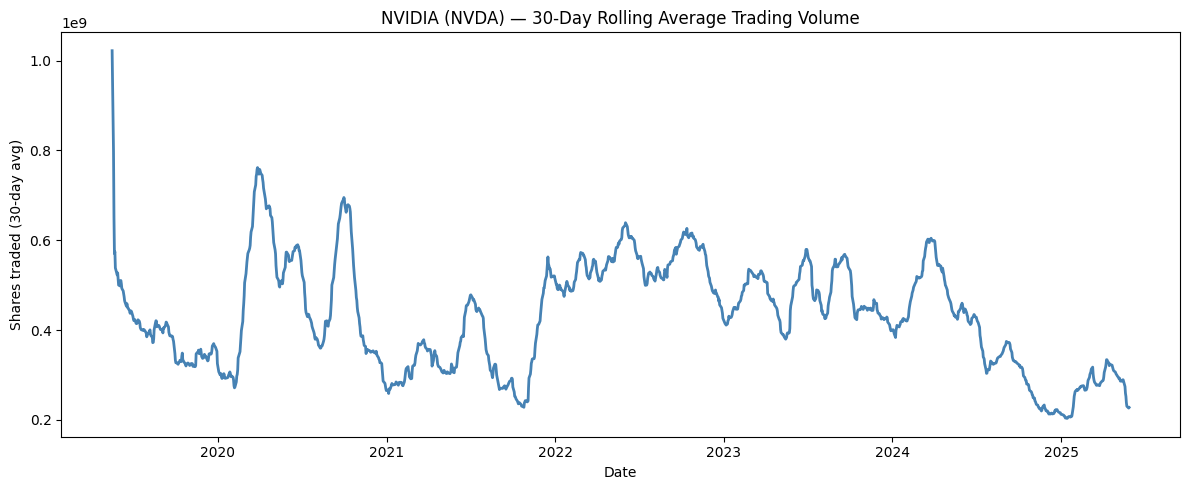

In [65]:
nvda_vol_roll = (
    all_stocks_data
    .query("name == 'NVDA'")
    .set_index("date")["volume"]
    .sort_index()
    .rolling(window=30, min_periods=1)
    .mean()
)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(nvda_vol_roll, lw=2, color="steelblue")
plt.title("NVIDIA (NVDA) — 30-Day Rolling Average Trading Volume")
plt.xlabel("Date")
plt.ylabel("Shares traded (30-day avg)")
plt.tight_layout()
plt.show()

Most volatile (by average 30-day std): NFLX


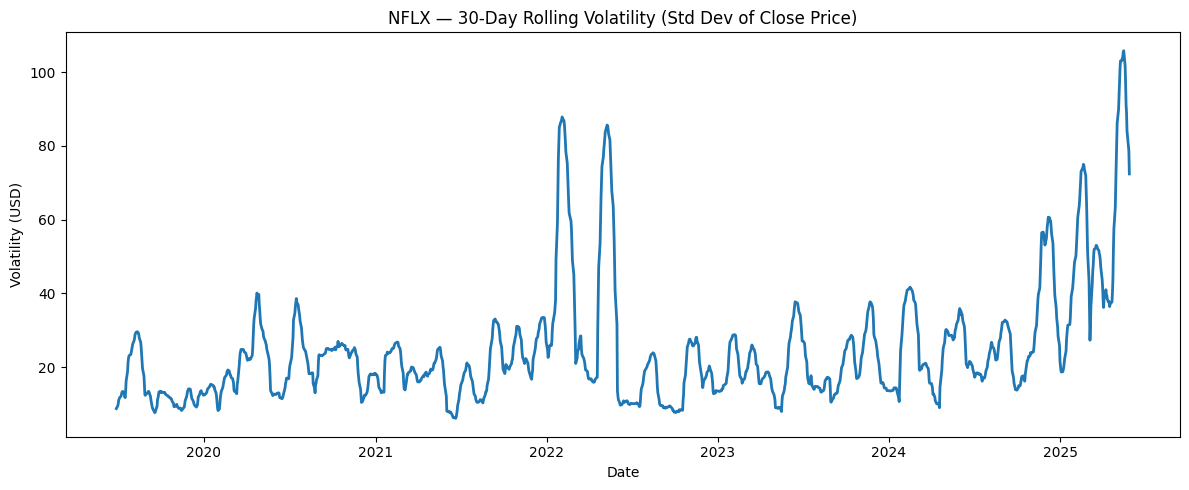

In [66]:
rolling_vol = close_px.rolling(window=30, min_periods=30).std()

avg_vol_per_ticker = rolling_vol.mean()
most_volatile_ticker = avg_vol_per_ticker.idxmax()
print(f"Most volatile (by average 30-day std): {most_volatile_ticker}")

vol_series = rolling_vol[most_volatile_ticker]

plt.figure(figsize=(12, 5))
plt.plot(vol_series, lw=2)
plt.title(f"{most_volatile_ticker} — 30-Day Rolling Volatility (Std Dev of Close Price)")
plt.xlabel("Date")
plt.ylabel("Volatility (USD)")
plt.tight_layout()
plt.show()

Highest average volume: NVDA


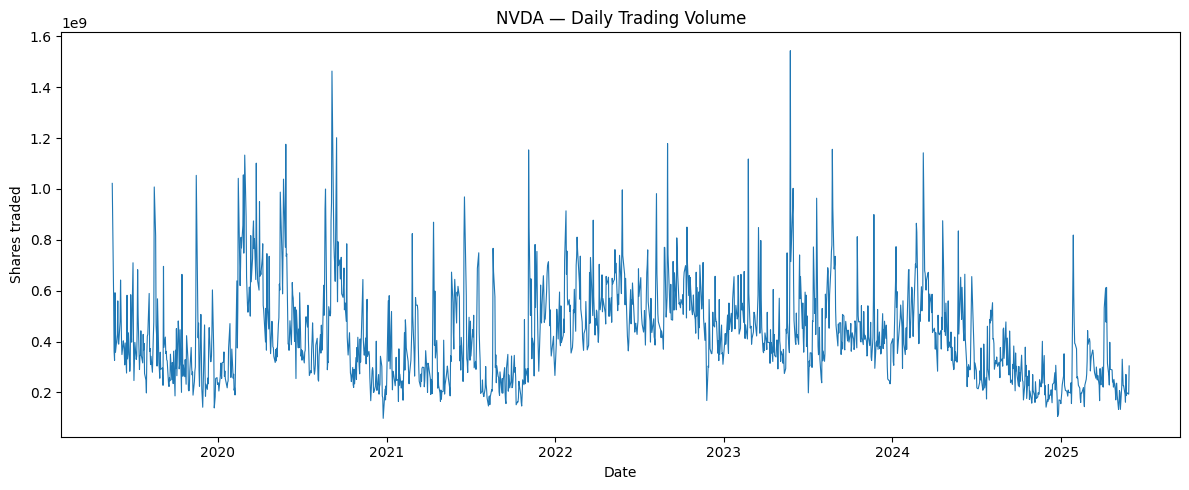

In [67]:
avg_vol = all_stocks_data.groupby("name")["volume"].mean()
top_vol_ticker = avg_vol.idxmax()
print(f"Highest average volume: {top_vol_ticker}")

top_vol_series = (
    all_stocks_data
    .query("name == @top_vol_ticker")
    .set_index("date")["volume"]
    .sort_index()
)

plt.figure(figsize=(12, 5))
plt.plot(top_vol_series, lw=0.8)
plt.title(f"{top_vol_ticker} — Daily Trading Volume")
plt.xlabel("Date")
plt.ylabel("Shares traded")
plt.tight_layout()
plt.show()

### Let's make a model on the Nvidia stock

In [68]:
nvda_close = (
    all_stocks_data
        .query("name == 'NVDA'")
        .set_index("date")["close"]
        .sort_index()
        
)

nvda_close.head()

date
2019-05-17    3.885397
2019-05-20    3.766747
2019-05-21    3.848908
2019-05-22    3.777917
2019-05-23    3.656785
Name: close, dtype: float64

In [69]:
train = nvda_close.loc[: '2023-12-31']
test  = nvda_close.loc['2024-01-01':]

print(f'Train: {train.shape} \nTest: {test.shape}')

Train: (1164,) 
Test: (352,)


In [70]:
print("Train shape:", train.shape)
print(train.head(10))
print(train.tail(10))
print("NaNs in train:", train.isna().sum())

Train shape: (1164,)
date
2019-05-17    3.885397
2019-05-20    3.766747
2019-05-21    3.848908
2019-05-22    3.777917
2019-05-23    3.656785
2019-05-24    3.602922
2019-05-28    3.557745
2019-05-29    3.483528
2019-05-30    3.456938
2019-05-31    3.366233
Name: close, dtype: float64
date
2023-12-15    48.871647
2023-12-18    50.058201
2023-12-19    49.585377
2023-12-20    48.092934
2023-12-21    48.971611
2023-12-22    48.811672
2023-12-26    49.260498
2023-12-27    49.398449
2023-12-28    49.503410
2023-12-29    49.503410
Name: close, dtype: float64
NaNs in train: 0


In [71]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import math
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


In [72]:
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1164
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1195.767
Date:                Fri, 30 May 2025   AIC                           2397.535
Time:                        13:35:49   BIC                           2412.711
Sample:                             0   HQIC                          2403.261
                               - 1164                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3884      1.094      0.355      0.723      -1.756       2.533
ma.L1         -0.4023      1.085     -0.371      0.711      -2.529       1.724
sigma2         0.4577      0.007     68.922      0.0

c:\Users\gregl\Desktop\ML_Projects\Algorithmic Trading\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gregl\Desktop\ML_Projects\Algorithmic Trading\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gregl\Desktop\ML_Projects\Algorithmic Trading\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gregl\Desktop\ML_Projects\Algorithmic Trading\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning

In [73]:
n_test = len(test)
forecast = model_fit.get_forecast(steps=n_test).predicted_mean
forecast = pd.Series(forecast, index=test.index)

c:\Users\gregl\Desktop\ML_Projects\Algorithmic Trading\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\gregl\Desktop\ML_Projects\Algorithmic Trading\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [74]:
forecast.isna().sum()

np.int64(352)

In [75]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import math
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


In [76]:
aligned = pd.concat([test, forecast], axis=1).dropna()
aligned.columns = ["actual", "predicted"]

In [77]:
#mae = mean_absolute_error(aligned["actual"], aligned["predicted"])
#mape = mean_absolute_percentage_error(aligned["actual"], aligned["predicted"]) * 100

#print(f"MAE : {mae:.4f}")
#print(f"MAPE: {mape:.2f}%")